### Load the main dataset containing target phenotype and clinical variables known to be associated with knee Osteoarthritis (KOA)

In [1]:
import warnings
warnings.simplefilter(action='ignore')


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import scipy as sp
import itertools
pd.options.display.max_rows = 2000

df = pd.read_csv('sample_all3.csv')
#print(df.head(5))

# Only considering baseline rows
df_bl = df[df['VISIT'] == 'V00']
df = df_bl

df.reset_index(drop=True, inplace=True)
df=df.set_index('ID')


#print(df_bl.shape)
df = df.drop(['FVDATE', 'BMI_BL_cat','TIME', 'AGE_BL_cat', "DATE", "TRAUMA_R", "TRAUMA_L", "VISIT", "XRKL", "XRKLL", "XRKLR", "BMI_BL", "AGE_BL", 'WOMTSL', 'WOMTSR', 'WOMTSmax', "ARTL",  "ARTR", 'XRKL_BL', 'XRKLR_BL', 'XRKLL_BL','KRSL', 'KRSR'], axis = 1)
#df = df.drop(['FVDATE', 'BMI_BL_cat','TIME', 'AGE_BL_cat', "DATE", "TRAUMA_R", "TRAUMA_L", "ID", "VISIT", "XRKLR", "BMI_BL", "AGE_BL", 'XRKL_BL', 'XRKLR_BL', 'XRKLL_BL','KRSL', 'KRSR'], axis = 1)

df = pd.get_dummies(df, columns = ['SEX', 'RACE'], drop_first=True)

x = df.loc[:, df.columns != 'pheno']
y = df['pheno']
nam_x = x.columns

x = pd.DataFrame(x, columns = nam_x)
y = np.ravel(pd.DataFrame(y))
n_samples = x.shape[0]
print(x.shape)
print(y.shape)
# print(x.iloc[:,0])

(4490, 5)
(4490,)


### Load other clinical variables and find continuous variables and discrete variables

In [3]:
clinical = pd.read_csv('clinical_all.csv', dtype="string")
clinical.replace(to_replace=pd.NA, value=None, inplace=True)

# baseline only
clinical = clinical[clinical['VISIT'] == 'V00']
clinical = clinical.drop(["ID", "VISIT", "V00ISEXMDT"], axis = 1)

# Identify columns which are continuous vs discreate
a = (clinical.fillna('1').apply(lambda x: pd.to_numeric(x, errors='coerce')))
# dummy columns index
dum_idx = a.isna().any()
# continous columns index
conti_idx = [not elem for elem in dum_idx]
# column names for dummy and conti
clin_cols = clinical.columns
dumcol = clin_cols[dum_idx]
conticol = clin_cols[conti_idx]
clinical.reset_index(drop=True, inplace=True)

In [53]:
print(conticol.shape)
print(dumcol.shape)

(161,)
(604,)


In [54]:
print(dumcol)

Index(['V00EXCESS1', 'V00HEMAT1', 'V00ILLPWK1', 'V00OTHVP1', 'V00QOVP1',
       'V00VCOLL1', 'V00VEIN1', 'V00VOID1', 'P02KPN', 'P01KPNREV',
       ...
       'V00PASE2HR', 'V00PASE3', 'V00PASE4', 'V00PASE5', 'V00PASE6',
       'V00WORK7', 'P01ARTLINJ', 'P01ARTRINJ', 'P01ARTL', 'P01ARTR'],
      dtype='object', length=604)


In [4]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.impute import SimpleImputer

# df_dum = clinical[dumcol]
# print(df_dum)

# pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(df_dum))
# ### Feature selection
# # from sklearn.feature_selection import f_classif
# # from sklearn.feature_selection import chi2, mutual_info_classif
# # from sklearn.feature_selection import SelectKBest

# # selector = SelectKBest(chi2, k)
# # selected_train = selector.fit_transform(df_dum, y)

### Make dataframe for continous clinical variables and discrete clinical variables respectively

In [5]:
df_dum = pd.concat([pd.get_dummies(clinical[col],drop_first=True) for col in dumcol], axis=1, keys=dumcol)
# df_dum = clinical[dumcol]
df_conti = clinical[conticol]
nam_conti = df_conti.columns

df_conti = (df_conti.apply(lambda x: pd.to_numeric(x, errors='coerce')))
# print(df_dum.head)
# print(df_conti.head)

nam_dum = df_dum.columns

df_dum.reset_index(drop=True, inplace=True)
df_conti.reset_index(drop=True, inplace=True)


In [66]:
print(df_dum.shape)

(4490, 1751)


### Split X, y, df_dum, df_conti into training and test dataset. Split the training dataset further into training and validation set.

In [63]:
indices = np.arange(n_samples)
x_train_val, x_test, y_train_val, y_test, \
        df_dum_train_val, df_dum_test, df_conti_train_val, df_conti_test, \
        indices_train_val, indices_test =  \
            train_test_split(x, y, df_dum, df_conti, indices, test_size=0.3, random_state = 7)
print(x_train_val.shape)
print(x_test.shape)

indices2 = np.arange(x_train_val.shape[0])
x_train, x_val, y_train, y_val, \
        df_dum_train, df_dum_val, df_conti_train, df_conti_val, \
        indices2_train, indices2_val =  \
            train_test_split(x_train_val, y_train_val, df_dum_train_val, df_conti_train_val, indices2, test_size=0.3, random_state = 7)
# print(indices2_train.shape)
# print(indices2_val.shape)
# print(x_train.shape)
# print(x_val.shape)
# print(x.shape)
# print(df_dum)

(3143, 5)
(1347, 5)


### Impute x and other clinical variables for training data and test data separately.

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
x_train = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(x_train), columns = nam_x)
x_val = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(x_val), columns = nam_x)
x_test = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(x_test), columns = nam_x)


### Normalize training and test data

In [8]:
from sklearn.preprocessing import StandardScaler

# normalization
std_scale = StandardScaler().fit(x_train)
x_train = pd.DataFrame(std_scale.transform(x_train), columns = nam_x)
x_val = pd.DataFrame(std_scale.transform(x_val), columns = nam_x)
x_test  = pd.DataFrame(std_scale.transform(x_test), columns = nam_x)
# print(x_train.head)

### Put train and validation together in x_train_val

In [9]:
x_train_val.iloc[indices2_train, :] = x_train
x_train_val.iloc[indices2_val, :] = x_val

### Pre-process clinical dataset
### Imputation

In [10]:
from sklearn.impute import SimpleImputer

#df_conti_train = (df_conti.apply(lambda x: pd.to_numeric(x, errors='coerce')))
df_conti_train = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(df_conti_train), columns = nam_conti)
df_conti_val = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(df_conti_val), columns = nam_conti)
df_conti_test = pd.DataFrame(SimpleImputer(strategy="most_frequent").fit_transform(df_conti_test), columns = nam_conti)

### Normalization

In [11]:
from sklearn.preprocessing import StandardScaler

# normalization 
scaler_conti = StandardScaler().fit(df_conti_train_val)
df_conti_train = pd.DataFrame(scaler_conti.transform(df_conti_train), columns = nam_conti)
df_conti_val = pd.DataFrame(scaler_conti.transform(df_conti_val), columns = nam_conti)
df_conti_test  = pd.DataFrame(scaler_conti.transform(df_conti_test), columns = nam_conti)

scaler = StandardScaler(with_mean=False).fit(df_dum_train_val)
df_dum_train = pd.DataFrame(scaler.transform(df_dum_train), columns = nam_dum)
df_dum_val = pd.DataFrame(scaler.transform(df_dum_val), columns = nam_dum)
df_dum_test  = pd.DataFrame(scaler.transform(df_dum_test), columns = nam_dum)


In [12]:
df_conti_train_val.iloc[indices2_train, :] = df_conti_train
df_conti_train_val.iloc[indices2_val, :] = df_conti_val

df_dum_train_val.iloc[indices2_train, :] = df_dum_train
df_dum_train_val.iloc[indices2_val, :] = df_dum_val

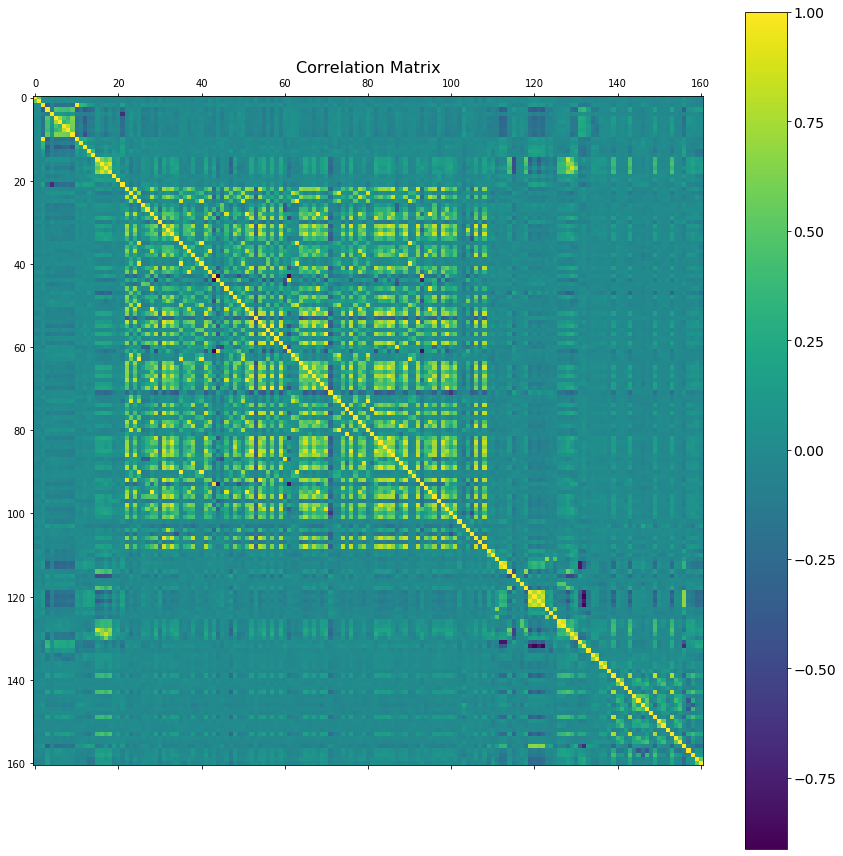

             WOMTSmax_BL       BMI       AGE     pheno     SEX_M  RACE_White
WOMTSmax_BL     1.000000  0.289458 -0.010345  0.272812 -0.096934   -0.318916
BMI             0.289458  1.000000 -0.075692  0.259781  0.036620   -0.207402
AGE            -0.010345 -0.075692  1.000000  0.212447 -0.028847    0.107710
pheno           0.272812  0.259781  0.212447  1.000000  0.018734   -0.061459
SEX_M          -0.096934  0.036620 -0.028847  0.018734  1.000000    0.096135
RACE_White     -0.318916 -0.207402  0.107710 -0.061459  0.096135    1.000000


In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.matshow(df_conti_train_val.corr(), fignum=1)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.xticks(range(df_conti_train_val.shape[1]), df_conti_train_val.columns, fontsize=14, rotation=45)
# plt.yticks(range(df_conti_train_val.shape[1]), df_conti_train_val.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

print(df.corr())

#plt.matshow(df_conti_train_val.corr())
#plt.show()

### Feature selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

df_dum_train.reset_index(drop=True, inplace=True)
df_conti_train.reset_index(drop=True, inplace=True)


allclinical_train = pd.concat([df_dum_train, df_conti_train], axis=1)
allclinical_val =pd.concat([df_dum_val, df_conti_val], axis=1)
allclinical_test = pd.concat([df_dum_test, df_conti_test], axis=1)
#print(allclinical_train)
#print(df_dum_train)



### Remove columns with no variability

In [15]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(allclinical_train)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in allclinical_train.columns
                    if column not in allclinical_train.columns[constant_filter.get_support()]]

print(constant_columns)
print(len(constant_columns))
allclinical_train= allclinical_train.drop(constant_columns,axis=1)
allclinical_val= allclinical_val.drop(constant_columns,axis=1)
allclinical_test= allclinical_test.drop(constant_columns,axis=1)

(2200, 1904)
[('P01RASTASV', '6: DK to RA/inflam arth, no/dk to meds'), ('V00FFQ34', '9: Every day'), ('V00FFQ42', '9: Every day'), ('V00FFQ45', '9: Every day'), ('V00WLK20T2', '3: Attempted, unable to complete'), ('V00400EXCL', '5: Excluded for other reason'), ('P01SVXRRID', 'C013'), ('P01SVXRRID', 'F004')]
8


In [16]:
print(df_conti_train.shape)
correlated_features = []
correlation_matrix = df_conti_train.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.append(colname)

df_conti_train.drop(labels=set(correlated_features), axis=1, inplace=True)
df_conti_val.drop(labels=set(correlated_features), axis=1, inplace=True)
df_conti_test.drop(labels=set(correlated_features), axis=1, inplace=True)
print(df_conti_train.shape)

(2200, 161)
(2200, 130)


In [17]:
set(correlated_features)

{'P01BPDAYCV',
 'V0020MPACE',
 'V00BAPCARB',
 'V00DTACAR',
 'V00DTARE',
 'V00DTB6',
 'V00DTBCAR',
 'V00DTCARB',
 'V00DTCYST',
 'V00DTDAID',
 'V00DTFAT',
 'V00DTLIN',
 'V00DTLUT',
 'V00DTMETH',
 'V00DTMG',
 'V00DTNA',
 'V00DTOLEC',
 'V00DTPOTA',
 'V00DTPROA',
 'V00DTPROT',
 'V00DTRIBO',
 'V00PCTFAT',
 'V00PCTPROT',
 'V00SRVDRY',
 'V00STEPST2',
 'V00SUPB1',
 'V00SUPB2',
 'V00SUPB6',
 'V00SUPCU',
 'V00SUPMG',
 'V00SUPNIAC'}

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

df_dum_train.reset_index(drop=True, inplace=True)
df_conti_train.reset_index(drop=True, inplace=True)
dummy_columns = df_dum_train.columns

allclinical_train = pd.concat([df_dum_train, df_conti_train], axis=1)
allclinical_val =pd.concat([df_dum_val, df_conti_val], axis=1)
allclinical_test = pd.concat([df_dum_test, df_conti_test], axis=1)
#print(allclinical_train)
#print(df_dum_train)



In [20]:
print(dummy_columns)

MultiIndex([('V00EXCESS1',                        '1: Yes'),
            ( 'V00HEMAT1',                        '1: Yes'),
            ('V00ILLPWK1',                        '1: Yes'),
            ( 'V00OTHVP1',                        '1: Yes'),
            (  'V00QOVP1',                  '2: Traumatic'),
            ( 'V00VCOLL1',                        '1: Yes'),
            (  'V00VEIN1',                        '1: Yes'),
            (  'V00VOID1',       '1: First void aliquoted'),
            (  'V00VOID1', '2: Second void only aliquoted'),
            (  'V00VOID1',    '3: Second plus later voids'),
            ...
            (  'V00PASE5',       '2: Sometimes (3-4 days)'),
            (  'V00PASE5',           '3: Often (5-7 days)'),
            (  'V00PASE6',          '1: Seldom (1-2 days)'),
            (  'V00PASE6',       '2: Sometimes (3-4 days)'),
            (  'V00PASE6',           '3: Often (5-7 days)'),
            (  'V00WORK7',                        '1: Yes'),
        

In [21]:
### Feature selection
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=30)
selected_train = selector.fit_transform(allclinical_train, y_train)

In [73]:
print(cols_conti.shape)

(30,)


In [22]:
cols_conti = selector.get_support(indices=True)
selected_train = allclinical_train.iloc[:,cols_conti]
selected_val = allclinical_val.iloc[:,cols_conti]
selected_test = allclinical_test.iloc[:,cols_conti]
nam_selected_train = selected_train.columns

In [23]:
dum_count = 0
dum_selected_features = []
conti_selected_features=[]

selected_cov = pd.DataFrame()
for c in nam_selected_train:
    if isinstance(c, tuple):
        dum_count += 1
        dum_selected_features.append(c[0])
    else:
        conti_selected_features.append(c)
        
dum_selected_features = np.unique(dum_selected_features)
print(dum_selected_features)

selected_dum = pd.concat([pd.get_dummies(clinical[col]) for col in dum_selected_features], axis=1, keys=dum_selected_features)


dum_train_val, dum_test, _, _ =  \
            train_test_split(selected_dum, y, test_size=0.3, random_state = 7)

dum_train, dum_val, _, _=  \
            train_test_split(dum_train_val,y_train_val, test_size=0.3, random_state = 7)

scaler = StandardScaler(with_mean=False).fit(dum_train_val)
dum_nam = dum_train.columns
dum_train = pd.DataFrame(scaler.transform(dum_train), columns = dum_nam)
dum_val = pd.DataFrame(scaler.transform(dum_val), columns = dum_nam)
dum_test  = pd.DataFrame(scaler.transform(dum_test), columns = dum_nam)

# selected_dum_train = allclinical_train.loc[:, conti_selected_features]

selected_conti_train = allclinical_train.loc[:, conti_selected_features]
selected_conti_val = allclinical_val.loc[:, conti_selected_features]
selected_conti_test = allclinical_test.loc[:, conti_selected_features]

# selected_dum_train = pd.concat([pd.get_dummies(clinical[col]) for col in dum_selected_features], axis=1, keys=dum_selected_features)
# print(selected_dum_train.shape)


['P01LSXKOA' 'P01LXRKOA' 'P01LXRKOA2' 'P01OAGRDL' 'P01OAGRDR' 'P01RSXKOA'
 'P01RXRKOA' 'P01RXRKOA2' 'P01SVLKJSM' 'P01SVLKOST' 'P01SVRKJSM'
 'P01SVRKOST' 'P01SXKOA' 'P01XRKOA' 'P02ELGRISK' 'P02IKPRISK' 'P02KPMEDCV'
 'P02KSURG' 'V00DIRKN7' 'V00FFQ25' 'V00KPRKN3' 'V00P7LKFR' 'V00SF3']


In [74]:
print(dum_selected_features.shape)
print(len(conti_selected_features))
print(dum_count)

(23,)
2
28


In [24]:
# cols_conti = selector.get_support(indices=True)
selected_train = pd.concat([pd.DataFrame(dum_train), pd.DataFrame(selected_conti_train)], axis=1)
selected_val = pd.concat([pd.DataFrame(dum_val), pd.DataFrame(selected_conti_val)], axis=1)
selected_test = pd.concat([pd.DataFrame(dum_test), pd.DataFrame(selected_conti_test)], axis=1)
nam_selected_train = selected_train.columns
print(selected_train.shape)
print(selected_val.shape)
print(selected_test.shape)

(2200, 94)
(943, 94)
(1347, 94)


In [25]:
# Get columns to keep and create new dataframe with those only
# cols_conti = selector.get_support(indices=True)
# selected_train = allclinical_train.iloc[:,cols_conti]
# selected_val = allclinical_val.iloc[:,cols_conti]
# selected_test = allclinical_test.iloc[:,cols_conti]
# nam_selected_train = selected_train.columns
#print(nam_selected_train)


nam_sel = list(selected_train.columns.values)
nam_sel = [''.join(item) for item in nam_sel]
selected_train.columns = nam_sel
selected_val.columns = nam_sel
selected_val.columns = nam_sel

cov_train = pd.concat([pd.DataFrame(x_train), pd.DataFrame(selected_train)], axis=1)
cov_val = pd.concat([pd.DataFrame(x_val), pd.DataFrame(selected_val)], axis=1)
cov_test = pd.concat([pd.DataFrame(x_test), pd.DataFrame(selected_test)], axis=1)

cov_train_val= pd.DataFrame(index=range(x_train_val.shape[0]), columns=pd.Index.union(x_train.columns, selected_train.columns))
cov_train_val.iloc[indices2_train, :] = cov_train
cov_train_val.iloc[indices2_val, :] = cov_val

In [26]:
print(cov_train.shape)

(2200, 99)


### Function for printinc p-values of the multinomial logistic regression

In [27]:
class MNLogisticReg(LogisticRegression):
    
    def __init__(self, *args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**args)
        if 'fit_intercept' in kwargs.keys():           
            self._fit_intercept = kwargs['fit_intercept']

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        p_values = []
        z_scores = []
        self.columns = list(X.columns)

        if self._fit_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])
           
        for i in range(denom.shape[1]):
            d = denom[:,i]        
            
            if self._fit_intercept:
                self.coef = np.column_stack((self.model.intercept_, self.model.coef_))
            else:
                self.coef = self.model.coef_
            
            d = np.tile(d,(X.shape[1],1)).T
            F_ij = np.dot((X/d).T,X) ## Fisher Information Matrix
            Cramer_Rao = sp.linalg.pinv(F_ij) ## Inverse Information Matrix  
            sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
            z_score = (self.coef[i]/sigma_estimates) # z-score for each model coefficient
            z_scores.append(z_score)
            p_vals = [sp.stats.norm.sf(abs(i))*2 for i in z_score] ### two tailed test for p-values
            p_values.append(p_vals)
            
        self.z_scores = np.array(z_scores)
        self.p_values = np.array(p_values)
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

    # A function to create an output in form of pandas dataframe, with regressors and intercept in
    # rows and coefficients in columns. Coefficients, p-values and z-scores are calculated for each
    # pair of classes in the dependent variable
    
    def printstats(self):      
        data = None
        for i in range(self.coef.shape[0]):
            if data is None:
                data = np.vstack(( self.coef[i,:], self.p_values[i,:], self.z_scores[i,:])).T
            else:
                d0 = np.vstack(( self.coef[i,:], self.p_values[i,:], self.z_scores[i,:])).T
                data = np.hstack((data,d0))
        # data is reshaped in the correct order
        regr = []
        for item in list(itertools.combinations(list([0,1,2]), 2)):
            regr.append('{} vs {}'.format(item[0], item[1]))
            
        functions = ['coef', 'P-value', 'Z-score']
        column_names = [([i] + [j]) for i in regr for j in functions] 
        index = pd.MultiIndex.from_tuples(column_names)
        predictors = self.columns
        if self._fit_intercept:
            ind = ['intercept'] + predictors
        else:
            ind = predictors
        self.stats = pd.DataFrame(data, columns = index, index = ind)
        # self.stats = pd.DataFrame(data)
        return self.stats

### Choose hyperparameter values using gridsearch on training and validation dataset

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


tuned_parameters_mlr = [
    {'solver' : ['saga'], 'penalty': ['l1','l2'], 'C': [0.6, 0.7, 0.8]},
    # {'solver' : ['lbfgs'], 'penalty': ['l2'], 'C': [0.7, 0.8]}
]

score = "precision_macro"

grid_search_multinom = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=0), tuned_parameters_mlr, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_multinom.fit(cov_train_val, y_train_val)

print("Chosen hyperparameter values are: ", grid_search_multinom.best_params_)
print("training recall is : ", grid_search_multinom.score(cov_train, y_train))
print("validation recall is : ", grid_search_multinom.score(cov_val, y_val))
print("test recall is: ", grid_search_multinom.score(cov_test, y_test))


Chosen hyperparameter values are:  {'C': 0.8, 'penalty': 'l1', 'solver': 'saga'}
training recall is :  0.6954643904653146
validation recall is :  0.6816985527791172
test recall is:  0.6692559467689861


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


tuned_parameters_mlrp = [
    {'solver' : ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.6, 0.7, 0.8]},
    # {'solver' : ['lbfgs'], 'penalty': ['l2'], 'C': [0.7, 0.8]}
]

score = "precision_macro"

grid_search_mlrp = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=0), tuned_parameters_mlrp, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_mlrp.fit(cov_train_val, y_train_val)

print("Chosen hyperparameter values are: ", grid_search_mlrp.best_params_)
print("training recall is : ", grid_search_mlrp.score(cov_train, y_train))
print("validation recall is : ", grid_search_mlrp.score(cov_val, y_val))
print("test recall is: ", grid_search_mlrp.score(cov_test, y_test))


Chosen hyperparameter values are:  {'C': 0.6, 'penalty': 'none', 'solver': 'saga'}
training recall is :  0.6968228390146526
validation recall is :  0.6806023781452449
test recall is:  0.673040774472455


### Fit multinomial logistic regression using the chosen hyperparameter values and summarize the values of the coefficient, p-values, and Z-scores for non-progression (0), slow-progression (1), and fast progression (2)

In [64]:
print(x.columns)
mp = MNLogisticReg(multi_class='multinomial', max_iter=5000, fit_intercept = True, \
                   C=grid_search_multinom.best_params_['C'], penalty = grid_search_multinom.best_params_['penalty'], \
                   solver = grid_search_multinom.best_params_['solver'])
mp.fit(cov_train, y_train)
# print(mp.model.score(cov_train, y_train))
# print(mp.model.score(x_val, y_val))
# print(mp.model.score(cov_test, y_test))
# print(mp.model.get_params())
mp.printstats()

Index(['WOMTSmax_BL', 'BMI', 'AGE', 'SEX_M', 'RACE_White'], dtype='object')


0 vs 1                \
                                                        coef       P-value   
intercept                                          -0.284575  5.413776e-01   
WOMTSmax_BL                                         0.066398  5.814888e-01   
BMI                                                -0.350423  1.371704e-08   
AGE                                                -0.291012  3.863813e-06   
SEX_M                                               0.107406  6.498426e-02   
RACE_White                                          0.102884  9.084535e-02   
P01LSXKOA0: No                                      0.196188  8.481436e-01   
P01LSXKOA1: Yes                                    -0.079282  9.188538e-01   
P01LXRKOA0: No                                      0.294523  7.931434e-01   
P01LXRKOA1: Yes                                    -0.200846  4.815411e-01   
P01LXRKOA20: Osteophytes=0 (none) and JSN=0 (none)  0.032570  9.298638e-01   
P01LXRKOA21: Osteophytes=0 (none) and JSN>0 (def)   0.158896  8.243709e-01   
P01LXRKOA22: Osteophytes=1 (poss) and JSN=0 (none)  0.188951  8.318581e-01   
P01LXRKOA23: Osteophytes=1 (poss) and JSN>0 (def)   0.104023  8.826090e-01   
P01LXRKOA24: Osteophytes=2 (def) and JSN=0 (none)  -0.229059  7.242263e-01   
P01LXRKOA25: Osteophytes=2 (def) and JSN=1 (mil...  0.195433  4.441151e-01   
P01LXRKOA26: Osteophytes=2 (def) and JSN=2 (sev... -0.382379  2.009889e-01   
P01OAGRDL0: Normal                                  0.032570  9.298638e-01   
P01OAGRDL1: Possible                               -0.360441  9.122338e-01   
P01OAGRDL2: Definite - mild                         0.826469  4.529090e-01   
P01OAGRDL3: Moderate                                0.195433  4.441151e-01   
P01OAGRDL4: Severe                                 -0.382379  2.009889e-01   
P01OAGRDR0: Normal                                  0.218264  1.388418e-02   
P01OAGRDR1: Possible                                0.529992  1.990701e-01   
P01OAGRDR2: Definite - mild                        -0.299044  4.854298e-01   
P01OAGRDR3: Moderate                               -0.124081  3.137994e-01   
P01OAGRDR4: Severe                                 -0.402422  1.864182e-03   
P01RSXKOA0: No                                      0.277370  4.751339e-01   
P01RSXKOA1: Yes                                    -0.096563  8.819350e-01   
P01RXRKOA0: No                                      0.138304  4.449435e-01   
P01RXRKOA1: Yes                                     0.009196  9.574720e-01   
P01RXRKOA20: Osteophytes=0 (none) and JSN=0 (none)  0.218264  1.388418e-02   
P01RXRKOA21: Osteophytes=0 (none) and JSN>0 (def)  -0.063611  4.893643e-01   
P01RXRKOA22: Osteophytes=1 (poss) and JSN=0 (none)  0.085997  4.906944e-01   
P01RXRKOA23: Osteophytes=1 (poss) and JSN>0 (def)  -0.131560  1.980671e-01   
P01RXRKOA24: Osteophytes=2 (def) and JSN=0 (none)   0.376955  1.451917e-01   
P01RXRKOA25: Osteophytes=2 (def) and JSN=1 (mil... -0.124081  3.137994e-01   
P01RXRKOA26: Osteophytes=2 (def) and JSN=2 (sev... -0.402422  1.864182e-03   
P01SVLKJSM0: 0  (normal, OARSI grade 0)             0.434329  7.359427e-01   
P01SVLKJSM1: 1 (narrowed, OARSI grade 1-2)          0.318488  7.939460e-01   
P01SVLKJSM2: 2 (severe, OARSI grade 3)             -0.905901  6.850476e-01   
P01SVLKOST0: 0 (none)                               0.085929  5.590602e-01   
P01SVLKOST1: 1 (possible, minute)                   0.235897  8.511170e-01   
P01SVLKOST2: 2 (definite, OARSI grade 1-3)         -0.200846  4.815411e-01   
P01SVRKJSM0: 0  (normal, OARSI grade 0)             0.113218  4.728713e-01   
P01SVRKJSM1: 1 (narrowed, OARSI grade 1-2)          0.173058  2.683716e-01   
P01SVRKJSM2: 2 (severe, OARSI grade 3)             -0.276158  4.413511e-01   
P01SVRKOST0: 0 (none)                               0.191085  1.810425e-02   
P01SVRKOST1: 1 (possible, minute)                  -0.017619  9.137499e-01   
P01SVRKOST2: 2 (definite, OARSI grade 1-3)          0.009196  9.574720e-01  

### Fit KNN

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


tuned_parameters_knn = [
    {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
    {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
]

score = "precision_macro"
# score = "accuracy"
# knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# knn.fit(x_train,y_train)
# print(knn.score(x_train, y_train))
grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_knn.fit(cov_train_val, y_train_val)
print("Chosen hyperparameter values are: ", grid_search_knn.best_params_)
print("training recall is : ", grid_search_knn.score(cov_train, y_train))
print("validation recall is: ", grid_search_knn.score(cov_val, y_val))
print("test recall is: ", grid_search_knn.score(cov_test, y_test))


Chosen hyperparameter values are:  {'metric': 'cosine', 'n_neighbors': 100, 'weights': 'uniform'}
training recall is :  0.6588233136157149
validation recall is:  0.6459137049746911
test recall is:  0.6562425021967905


### SVM

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# tuned_parameters_svm = [
#     {"kernel": ["rbf", "sigmoid"], "gamma": ['scale', 0.2, 0.3], "C": [0.8, 0.9, 1, 1.1]},
#     {"kernel": ["linear"], "C": [0.9, 1, 1.1]},
#     {"kernel": ["poly"], "degree":[2,3], "C": [0.9, 1, 1.1]}
# ]

tuned_parameters_svm = [
    {"kernel": ["rbf", "poly"], "gamma": ['scale', 0.2], "C": [0.8, 0.9, 1, 1.5]},
    {"kernel": ["linear"], "C": [0.85, 0.9, 1]}
]

score = "precision_macro"

#svc = SVC(probability=True, kernel = "rbf", C=1)
#svc.fit(x_train, y_train)
#svc.score(x_train, y_train)
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=0), tuned_parameters_svm, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_svm.fit(cov_train_val, y_train_val)

print("Chosen hyperparameter values are: ", grid_search_svm.best_params_)
print("training recall is : ", grid_search_svm.score(cov_train, y_train))
print("validation recall is: ", grid_search_svm.score(cov_val, y_val))
print("test recall is: ", grid_search_svm.score(cov_test, y_test))


Chosen hyperparameter values are:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
training recall is :  0.7476872433555991
validation recall is:  0.7354978354978355
test recall is:  0.6708101259011491


In [33]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# tuned_parameters_svm = [
#     {"kernel": ["rbf", "sigmoid"], "gamma": ['scale', 0.2, 0.3], "C": [0.8, 0.9, 1, 1.1]},
#     {"kernel": ["linear"], "C": [0.9, 1, 1.1]},
#     {"kernel": ["poly"], "degree":[2,3], "C": [0.9, 1, 1.1]}
# ]

tuned_parameters_svmp = [
    {"penalty": ['l1', 'l2'], 'loss': ['squared_hinge'], "C": [0.8, 0.9, 1, 1.5]}
]

score = "precision_macro"

#svc = SVC(probability=True, kernel = "rbf", C=1)
#svc.fit(x_train, y_train)
#svc.score(x_train, y_train)
grid_search_svmp = GridSearchCV(LinearSVC(random_state=0), tuned_parameters_svmp, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_svmp.fit(cov_train_val, y_train_val)

print("Chosen hyperparameter values are: ", grid_search_svmp.best_params_)
print("training recall is : ", grid_search_svmp.score(cov_train, y_train))
print("validation recall is: ", grid_search_svmp.score(cov_val, y_val))
print("test recall is: ", grid_search_svmp.score(cov_test, y_test))


Chosen hyperparameter values are:  {'C': 0.8, 'loss': 'squared_hinge', 'penalty': 'l2'}
training recall is :  0.6873998323174636
validation recall is:  0.6746583424801091
test recall is:  0.6714851265806687


In [34]:
# print(grid_search_svm.best_estimator_.coef_.shape)
# grid_search_svm.best_estimator_.coef_

### Fit neural network

In [35]:
import torch
from torch import nn
from skorch import NeuralNetClassifier


class CustomModel(nn.Module):
    def __init__(self, num_units=10):
        super(CustomModel, self).__init__()
        
        self.D_in = cov_train.shape[1]
        self.H1 = num_units
        self.H2 = num_units
        self.D_out = 3
        
        self.linear1 = nn.Linear(self.D_in, self.H1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.H1, self.H2)
        self.linear3 = nn.Linear(self.H2, self.D_out)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        linear1 = self.linear1(x)
        relu1 = self.relu(linear1)
        relu1 = self.dropout(relu1)
        linear2 = self.linear2(relu1)
        relu2 = self.relu(linear2)
        relu2 = self.dropout(relu2)
        linear2 = self.linear2(relu2)
        relu2 = self.relu(linear2)
        relu2 = self.dropout(relu2)
        output = self.linear3(relu2)
        return output
    
net = NeuralNetClassifier(CustomModel(), criterion=nn.CrossEntropyLoss())
net.set_params(train_split=False, verbose=0)

params = {
    'batch_size': [64, 128],
    'lr': [0.01, 0.02],
    'max_epochs': [40],
    'module__num_units': [10, 20],
    'optimizer': [torch.optim.Adam]
}

# params = {
#     'batch_size': [32],
#     'lr': [0.01],
#     'max_epochs': [30],
#     'module__num_units': [10],
#     'optimizer': [torch.optim.Adam]
# }
score = "precision_macro"


gs = GridSearchCV(net, params, refit=score, scoring=score, cv = [(indices2_train, indices2_val)])
gs.fit(torch.from_numpy(cov_train_val.to_numpy().astype(float)).type(torch.FloatTensor), torch.from_numpy(y_train_val).type(torch.LongTensor))
print(gs.best_score_, gs.best_params_)
print("Chosen hyperparameter values are: ", gs.best_params_)
print("training recall is : ", gs.score(torch.from_numpy(cov_train.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.LongTensor)))
print("validation recall is: ", gs.score(torch.from_numpy(cov_val.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.LongTensor)))
print("test recall is: ", gs.score(torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_test).type(torch.LongTensor)))


0.6884113436687832 {'batch_size': 64, 'lr': 0.02, 'max_epochs': 40, 'module__num_units': 10, 'optimizer': <class 'torch.optim.adam.Adam'>}
Chosen hyperparameter values are:  {'batch_size': 64, 'lr': 0.02, 'max_epochs': 40, 'module__num_units': 10, 'optimizer': <class 'torch.optim.adam.Adam'>}
training recall is :  0.6925080793570633
validation recall is:  0.679445955353022
test recall is:  0.6588598251843906


### Fit AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tuning_parameters_abc = [
    {"base_estimator__criterion": ["gini", "entropy"], 
     "base_estimator__max_depth": [1, 5], 
     "base_estimator__max_features": [None, "sqrt", "log2"],
     "n_estimators": [50, 70],
     "learning_rate": [0.9, 0.95]}
    ]

score = "precision_macro"

abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state=0)

grid_search_abc = GridSearchCV(abc, tuning_parameters_abc, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_abc.fit(cov_train_val, y_train_val)
# print(grid_search_abc.cv_results_)

print("Chosen hyperparameter values are: ", grid_search_abc.best_params_)
print("training recall is : ", grid_search_abc.score(cov_train, y_train))
print("validation recall is: ", grid_search_abc.score(cov_val, y_val))
print("test recall is: ", grid_search_abc.score(cov_test, y_test))


Chosen hyperparameter values are:  {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'learning_rate': 0.9, 'n_estimators': 50}
training recall is :  0.6671747793747717
validation recall is:  0.6758223795526085
test recall is:  0.6649206901158714


### Fit RandomForest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# tuning_parameters = [
#     {"base_estimator__criterion": ["gini", "entropy"], 
#      "base_estimator__max_depth": [5, 9, 10, 15], 
#      "n_estimators": [100, 1000, 2000],
#      "learning_rate": [1e-1, 1e-3, 1e-5, 1e-7]}
#     ]

tuning_parameters_rf = [
    {"criterion": ["gini", "entropy"], 
     "max_features": ["sqrt", "log2"], 
     "n_estimators": [38, 40, 42,100],
     "max_samples": [None, 0.5],
     "max_depth": [None, 8, 10,12]
    }
    ]

score = "precision_macro"

rf = RandomForestClassifier(random_state=0)

grid_search_rf = GridSearchCV(rf, tuning_parameters_rf, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
grid_search_rf.fit(cov_train_val, y_train_val)
# print(grid_search_abc.cv_results_)

print("Chosen hyperparameter values are: ", grid_search_rf.best_params_)
print("training recall is : ", grid_search_rf.score(cov_train, y_train))
print("validation recall is: ", grid_search_rf.score(cov_val, y_val))
print("test recall is: ", grid_search_rf.score(cov_test, y_test))


Chosen hyperparameter values are:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 40}
training recall is :  0.7926939843030484
validation recall is:  0.8065097544084088
test recall is:  0.6689311615049564


### ROC, Confusion matrix, Test accuracy, precision, recall of multinomial logistic model

Accuracy: 0.6622123236822569 
Precision: 0.6692559467689861 
Recall: 0.6670357583153667


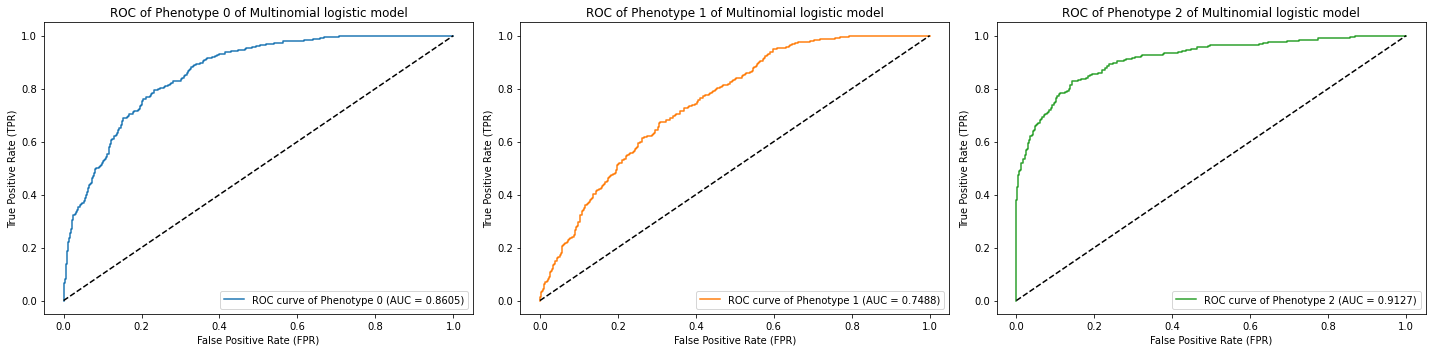

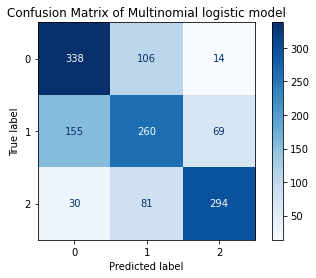

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

y_score_multinom = grid_search_multinom.predict_proba(cov_test)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]
# print(n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_multinom[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, n_classes, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of Multinomial logistic model')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()

y_pred = grid_search_multinom.predict(cov_test)
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(grid_search_multinom, cov_test, y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of Multinomial logistic model")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

### ROC, Confusion matrix, Test accuracy, precision, recall of SVM

Accuracy: 0.6644394951744618 
Precision: 0.6708101259011491 
Recall: 0.6703038798138264


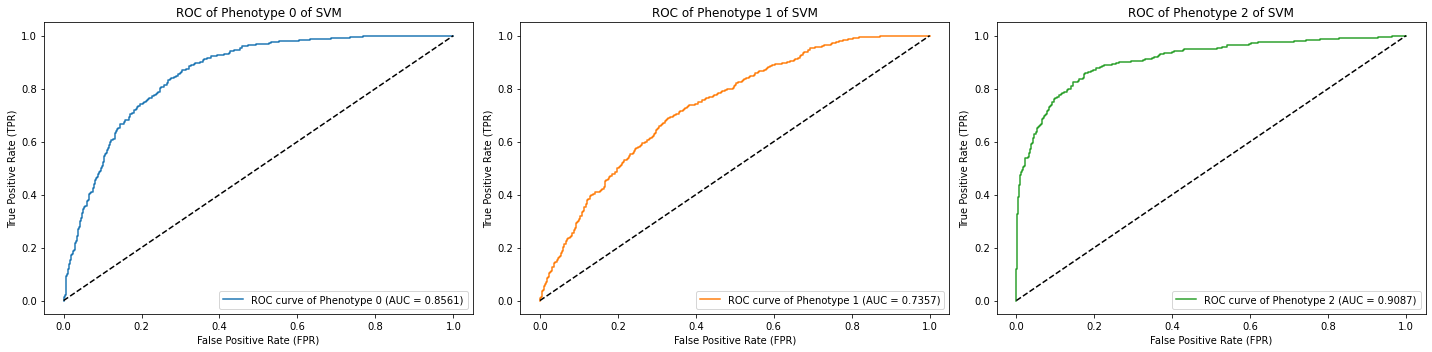

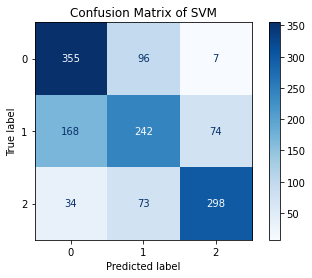

In [39]:
y_score_svm = grid_search_svm.predict_proba(cov_test)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]
# print(n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, n_classes, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of SVM')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()

y_pred = grid_search_svm.predict(cov_test)
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(grid_search_svm, cov_test, y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of SVM")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

### ROC, Confusion matrix, Test accuracy, precision, recall of KNN

Accuracy: 0.6332590942835932 
Precision: 0.6503738934425748 
Recall: 0.6354211472049238


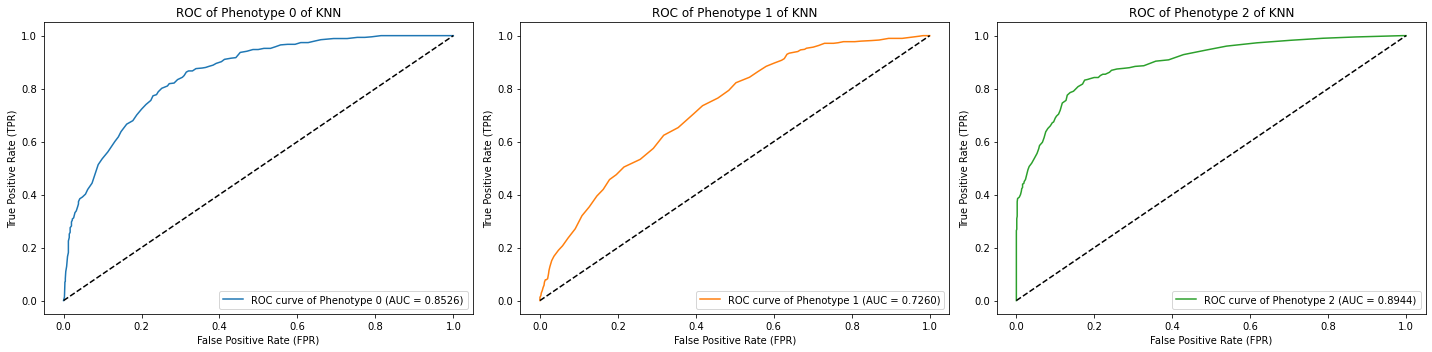

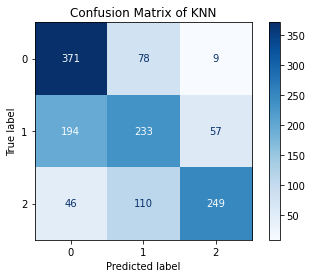

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

y_score_knn = grid_search_knn.predict_proba(cov_test)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]
# print(n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of KNN')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()


y_pred = grid_search_knn.predict(cov_test)
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(grid_search_knn, cov_test, y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of KNN")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

### ROC, Confusion matrix, Test accuracy, precision, recall of Neural Network

Accuracy: 0.6488492947290274 
Precision: 0.6588598251843906 
Recall: 0.6569748772033629


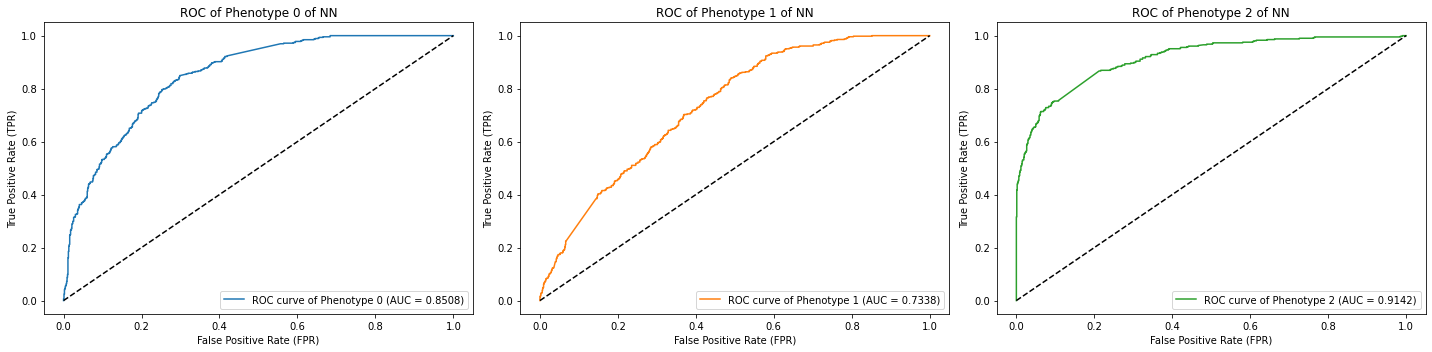

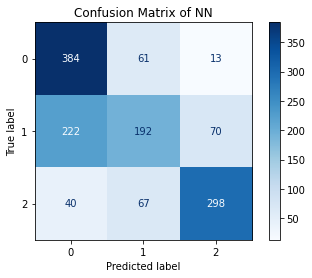

In [41]:
cov_test_tensor = torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor)
y_score_mlp = gs.predict_proba(cov_test_tensor)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, n_classes, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of NN')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()


y_pred_nn = gs.predict(torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor))
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(gs, torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor), y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of NN")

acc = accuracy_score(y_test, y_pred_nn)
prec = precision_score(y_test, y_pred_nn, average="macro")
rec = recall_score(y_test, y_pred_nn, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

### ROC, Confusion matrix, Test accuracy, precision, recall of RandomForest

Accuracy: 0.6659242761692651 
Precision: 0.6689311615049564 
Recall: 0.6725655240894973


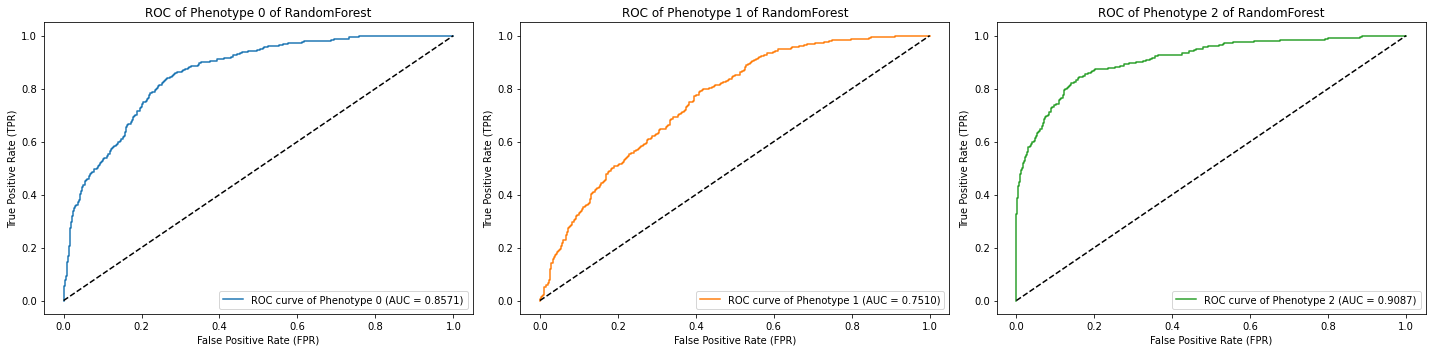

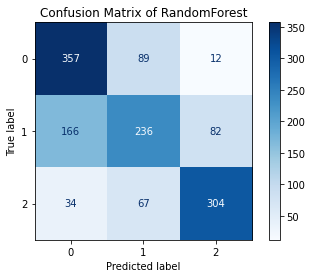

In [42]:
y_score_rf = grid_search_rf.predict_proba(cov_test)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]
# print(n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, n_classes, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of RandomForest')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()

y_pred = grid_search_rf.predict(cov_test)
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(grid_search_rf, cov_test, y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of RandomForest")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

### ROC, Confusion matrix, Test accuracy, precision, recall of AdaBoost

Accuracy: 0.6555308092056422 
Precision: 0.6649206901158714 
Recall: 0.6601386663007235


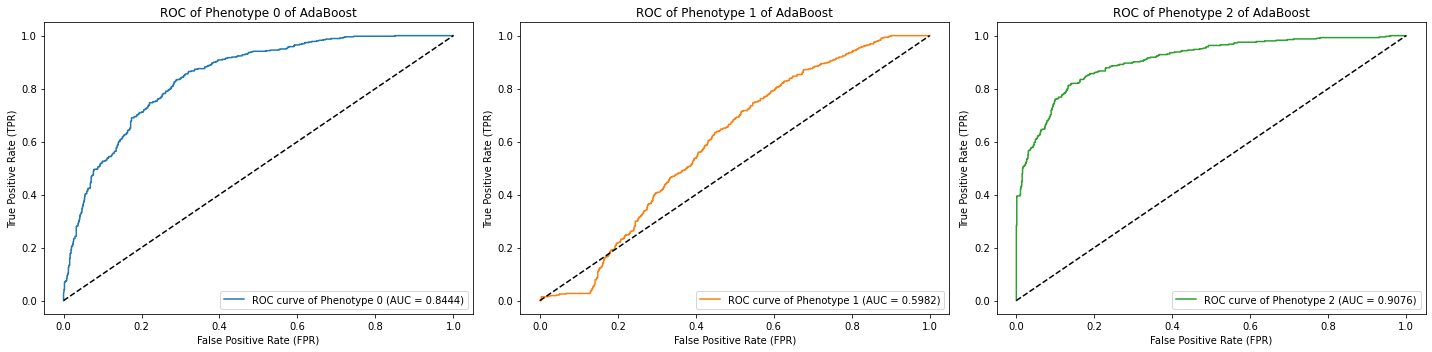

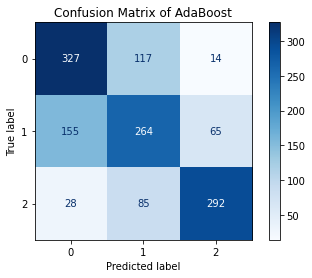

In [43]:
y_score_abc = grid_search_abc.predict_proba(cov_test)
y_test_bin = label_binarize(y_test, classes=range(0,3))
n_classes = y_test_bin.shape[1]
# print(n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_abc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['C0', 'C1', 'C2']

idx = 0
fig, axs = plt.subplots(1, n_classes, figsize=(20, 5))
for j in range(n_classes):
    axs[j].plot(fpr[idx], tpr[idx], color=colors[idx], label='ROC curve of Phenotype {0} (AUC = {1:0.4f})'.format(idx, roc_auc[idx]))
    axs[j].plot([0, 1], [0, 1], 'k--')
    axs[j].legend(loc="lower right")
    axs[j].title.set_text(f'ROC of Phenotype {idx} of AdaBoost')
    idx += 1
    axs[j].set_xlabel('False Positive Rate (FPR)')
    axs[j].set_ylabel('True Positive Rate (TPR)')
fig.tight_layout()

###
y_pred = grid_search_abc.predict(cov_test)
# print(confusion_matrix(y_test, y_pred))

confusion = ConfusionMatrixDisplay.from_estimator(grid_search_abc, cov_test, y_test, display_labels=range(n_classes), cmap=plt.cm.Blues)
confusion.ax_.set_title("Confusion Matrix of AdaBoost")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
print(f'Accuracy: {acc} \nPrecision: {prec} \nRecall: {rec}')

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [126]:
# print("test recall is: ", grid_search_multinom.score(cov_test, y_test))

    # MLR
print("MLR")
print(grid_search_multinom.best_params_)
print("test recall is: ", grid_search_multinom.score(cov_test, y_test))
y_pred = grid_search_multinom.predict(cov_test)
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",grid_search_multinom.score(cov_train, y_train))
print("validation recall is: ",grid_search_multinom.score(cov_val, y_val))

    #KNN
print("KNN")
print(grid_search_knn.best_params_)
y_pred = grid_search_knn.predict(cov_test)
print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",grid_search_knn.score(cov_train, y_train))
print("validation recall is: ",grid_search_knn.score(cov_val, y_val))

    # SVM
print("SVM")
print(grid_search_svm.best_params_)
y_pred = grid_search_svm.predict(cov_test)
print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",grid_search_svm.score(cov_train, y_train))
print("validation recall is: ",grid_search_svm.score(cov_val, y_val))

    # NN
print("NN")
print(gs.best_params_)
print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
y_pred = gs.predict(torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor))
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred_nn))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",gs.score(torch.from_numpy(cov_train.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.LongTensor)))
print("validation recall is: ",gs.score(torch.from_numpy(cov_val.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.LongTensor))
)
    # RF
print("RF")
print(grid_search_rf.best_params_)
y_pred = grid_search_rf.predict(cov_test)
print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",grid_search_rf.score(cov_train, y_train))
print("validation recall is: ",grid_search_rf.score(cov_val, y_val))
    # ABC
print("ABC")
print(grid_search_abc.best_params_)
y_pred = grid_search_abc.predict(cov_test)
print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
print("test precision is", precision_score(y_test, y_pred, average="macro"))
print("test accuracy is", accuracy_score(y_test, y_pred))
#print("test precision is", recall_score(y_test, y_pred, average="micro"))
print("train recall is: ",grid_search_abc.score(cov_train, y_train))
print("validation recall is: ",grid_search_abc.score(cov_val, y_val))



#     # MLRP
# print("MLR_P")
# print(grid_search_mlrp.best_params_)
# print("test recall is: ", grid_search_mlrp.score(cov_test, y_test))
# y_pred = grid_search_mlrp.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_mlrp.score(cov_train, y_train))
# print("validation recall is: ",grid_search_mlrp.score(cov_val, y_val))

#     # SVMP
# print("SVM_P")
# print(grid_search_svmp.best_params_)
# print("test recall is: ", grid_search_svmp.score(cov_test, y_test))
# y_pred = grid_search_svmp.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_svmp.score(cov_train, y_train))
# print("validation recall is: ",grid_search_svmp.score(cov_val, y_val))


MLR
{'C': 0.8, 'penalty': 'l1', 'solver': 'saga'}
test recall is:  0.6692559467689861
test precision is 0.6692559467689861
test accuracy is 0.6622123236822569
train recall is:  0.6954643904653146
validation recall is:  0.6816985527791172
KNN
{'metric': 'cosine', 'n_neighbors': 100, 'weights': 'uniform'}
test recall is:  0.6466971926192957
test precision is 0.6562425021967905
test accuracy is 0.6429101707498144
train recall is:  0.6588233136157149
validation recall is:  0.6459137049746911
SVM
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
test recall is:  0.6703038798138264
test precision is 0.6708101259011491
test accuracy is 0.6644394951744618
train recall is:  0.7476872433555991
validation recall is:  0.7354978354978355
NN
{'batch_size': 64, 'lr': 0.02, 'max_epochs': 40, 'module__num_units': 10, 'optimizer': <class 'torch.optim.adam.Adam'>}
test recall is:  0.6703038798138264
test precision is 0.6588598251843906
test accuracy is 0.6488492947290274
train recall is:  0.6925080793570633
va

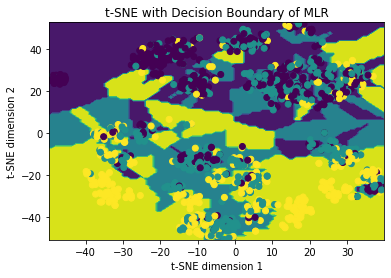

In [120]:
import numpy as np, matplotlib.pyplot as plt

# from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# replace the below by your data and model
#iris = load_iris()
# cov_train,y_train = iris.data, iris.target
X_Train_embedded = TSNE(n_components=2).fit_transform(cov_test)
#print X_Train_embedded.shape
model = grid_search_multinom
y_predicted = model.predict(cov_test)
# multi_class='multinomial', max_iter=5000, fit_intercept = True, \
#                    C=grid_search_multinom.best_params_['C'], penalty = grid_search_multinom.best_params_['penalty'], \
#                    solver = grid_search_multinom.best_params_['solver'])
# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of MLR")
plt.show()

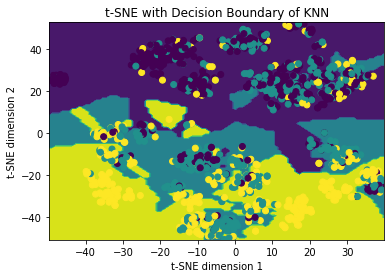

In [121]:
model = grid_search_knn
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])

y_predicted = model.predict(cov_test)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of KNN")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

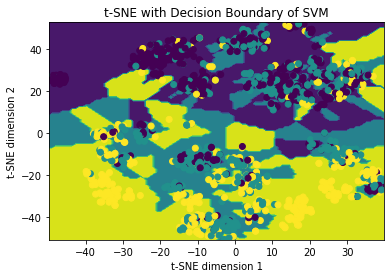

In [125]:
model = grid_search_svm
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])

y_predicted = model.predict(cov_test)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of SVM")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

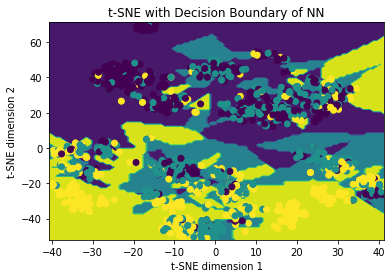

In [111]:
model = gs
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])

cov_test_tensor = torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor)

y_predicted = model.predict(cov_test_tensor)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of NN")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

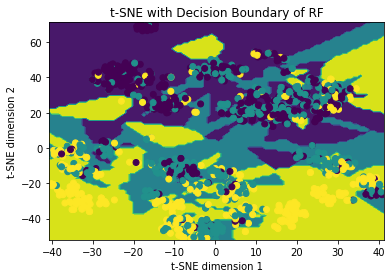

In [112]:
model = grid_search_rf
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])

y_predicted = model.predict(cov_test)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of RF")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

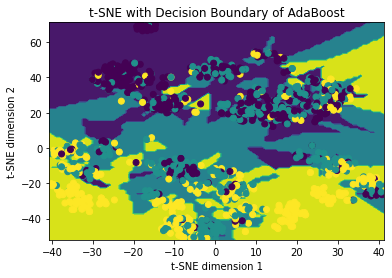

In [113]:
model = grid_search_abc
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])

y_predicted = model.predict(cov_test)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of AdaBoost")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

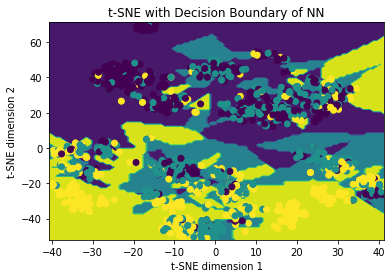

In [114]:
model = gs
# model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], p= grid_search_knn.best_params_['p'], weights = grid_search_knn.best_params_['weights'])
cov_test_tensor = torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor)
y_predicted = model.predict(cov_test_tensor)
# tuned_parameters_knn = [
#     {"n_neighbors": [40,50, 75, 100], "p": [1, 2], "weights": ['uniform']}, #, 'distance'
#     {'n_neighbors': [40, 50, 75, 100], "metric": ['cosine'], "weights": ['uniform', 'distance']}
# ]

# score = "precision_macro"
# # score = "accuracy"
# # knn=KNeighborsClassifier(n_neighbors = 3, p=1)
# # knn.fit(x_train,y_train)
# # print(knn.score(x_train, y_train))
# grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])

# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.contourf(xx, yy, voronoiBackground)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of NN")
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.show()

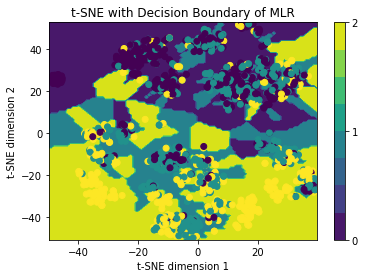

In [129]:
fig, ax = plt.subplots()
im = ax.contourf(xx, yy, voronoiBackground)
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y_test)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE with Decision Boundary of MLR")
fig.colorbar(im, ax=ax, ticks=[0,1,2])
plt.show()

In [130]:
# ### Feature selection
# num_feat = [10, 20, 30]
# acc_mul = []
# acc_knn = []
# acc_svm = []
# acc_nn = []
# acc_rf=[]
# acc_abc = []

# for n in num_feat:
#     print("number of additional features is", n)
#     selector = SelectKBest(mutual_info_classif, k=n)
#     selected_train = selector.fit_transform(allclinical_train, y_train)

#     # Get columns to keep and create new dataframe with those only
#     cols_conti = selector.get_support(indices=True)
#     selected_train = allclinical_train.iloc[:,cols_conti]
#     selected_val = allclinical_val.iloc[:,cols_conti]
#     selected_test = allclinical_test.iloc[:,cols_conti]
#     nam_selected_train = selected_train.columns
    
    
    
#     ###
#     dum_count = 0
#     dum_selected_features = []
#     conti_selected_features=[]

#     selected_cov = pd.DataFrame()
#     for c in nam_selected_train:
#         if isinstance(c, tuple):
#             dum_count += 1
#             dum_selected_features.append(c[0])
#         else:
#             conti_selected_features.append(c)

#     dum_selected_features = np.unique(dum_selected_features)
#     print(dum_selected_features)

#     selected_dum = pd.concat([pd.get_dummies(clinical[col]) for col in dum_selected_features], axis=1, keys=dum_selected_features)


#     dum_train_val, dum_test, _, _ =  \
#                 train_test_split(selected_dum, y, test_size=0.3, random_state = 7)

#     dum_train, dum_val, _, _=  \
#                 train_test_split(dum_train_val,y_train_val, test_size=0.3, random_state = 7)

#     scaler = StandardScaler(with_mean=False).fit(dum_train_val)
#     dum_nam = dum_train.columns
#     dum_train = pd.DataFrame(scaler.transform(dum_train), columns = dum_nam)
#     dum_val = pd.DataFrame(scaler.transform(dum_val), columns = dum_nam)
#     dum_test  = pd.DataFrame(scaler.transform(dum_test), columns = dum_nam)

#     # selected_dum_train = allclinical_train.loc[:, conti_selected_features]

#     selected_conti_train = allclinical_train.loc[:, conti_selected_features]
#     selected_conti_val = allclinical_val.loc[:, conti_selected_features]
#     selected_conti_test = allclinical_test.loc[:, conti_selected_features]

#     # selected_dum_train = pd.concat([pd.get_dummies(clinical[col]) for col in dum_selected_features], axis=1, keys=dum_selected_features)
#     # print(selected_dum_train.shape)

#     selected_train = pd.concat([pd.DataFrame(dum_train), pd.DataFrame(selected_conti_train)], axis=1)
#     selected_val = pd.concat([pd.DataFrame(dum_val), pd.DataFrame(selected_conti_val)], axis=1)
#     selected_test = pd.concat([pd.DataFrame(dum_test), pd.DataFrame(selected_conti_test)], axis=1)
#     nam_selected_train = selected_train.columns
#     print(selected_train.shape)
#     #print(selected_val.shape)
#     #print(selected_test.shape)

#     nam_sel = list(selected_train.columns.values)
#     nam_sel = [''.join(item) for item in nam_sel]
#     selected_train.columns = nam_sel
#     selected_val.columns = nam_sel
#     selected_val.columns = nam_sel

#     cov_train = pd.concat([pd.DataFrame(x_train), pd.DataFrame(selected_train)], axis=1)
#     cov_val = pd.concat([pd.DataFrame(x_val), pd.DataFrame(selected_val)], axis=1)
#     cov_test = pd.concat([pd.DataFrame(x_test), pd.DataFrame(selected_test)], axis=1)

#     cov_train_val= pd.DataFrame(index=range(x_train_val.shape[0]), columns=pd.Index.union(x_train.columns, selected_train.columns))
#     cov_train_val.iloc[indices2_train, :] = cov_train
#     cov_train_val.iloc[indices2_val, :] = cov_val
#     print(cov_train_val.shape)


#     ### run algorithms
#     # MLR
#     print("MLR")
#     grid_search_multinom = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=5000, random_state=0), tuned_parameters_mlrp, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
#     grid_search_multinom.fit(cov_train_val, y_train_val)
#     acc_mul.append(grid_search_multinom.score(cov_val, y_val))
#     print(grid_search_multinom.score(cov_val, y_val))
#     print(grid_search_multinom.best_params_)
#     #KNN
#     print("KNN")
#     grid_search_knn = GridSearchCV(KNeighborsClassifier(), tuned_parameters_knn, scoring=score, refit = score)
#     grid_search_knn.fit(cov_train_val, y_train_val)
#     acc_knn.append(grid_search_knn.score(cov_val, y_val))
#     print(grid_search_knn.score(cov_val, y_val))
#     print(grid_search_knn.best_params_)
#     # SVM
#     print("SVM")
#     grid_search_svm = GridSearchCV(SVC(probability=True, random_state=0), tuned_parameters_svm, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
#     grid_search_svm.fit(cov_train_val, y_train_val)
#     acc_svm.append(grid_search_svm.score(cov_val, y_val))
#     print(grid_search_svm.score(cov_val, y_val))
#     print(grid_search_svm.best_params_)
#     # NN
#     print("NN")
#     gs = GridSearchCV(net, params, refit=score, scoring=score, cv = [(indices2_train, indices2_val)])
#     gs.fit(torch.from_numpy(cov_train_val.to_numpy().astype(float)).type(torch.FloatTensor), torch.from_numpy(y_train_val).type(torch.LongTensor))
#     acc_nn.append(gs.score(torch.from_numpy(cov_val.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.LongTensor)))
#     print(gs.score(torch.from_numpy(cov_val.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.LongTensor)))
#     print(gs.best_params_)
#     # RF
#     print("RF")
#     grid_search_rf = GridSearchCV(rf, tuning_parameters_rf, scoring=score, refit = score,cv = [(indices2_train, indices2_val)])
#     grid_search_rf.fit(cov_train_val, y_train_val)
#     acc_rf.append(grid_search_rf.score(cov_val, y_val))
#     print(grid_search_rf.score(cov_val, y_val))
#     print(grid_search_rf.best_params_)
#     # ABC
#     print("ABC")
#     grid_search_abc = GridSearchCV(abc, tuning_parameters_abc, scoring=score, refit = score, cv = [(indices2_train, indices2_val)])
#     grid_search_abc.fit(cov_train_val, y_train_val)
#     acc_abc.append(grid_search_abc.score(cov_val, y_val))
#     print(grid_search_abc.score(cov_val, y_val))
#     print(grid_search_abc.best_params_)



In [46]:

# num_feat2 = [10, 20, 30]
# print(acc_mul)
# print(acc_knn)
# print(acc_svm)
# print(acc_nn)
# print(acc_rf)
# print(acc_abc)

# plt.plot(num_feat2, acc_mul, label = "MLR")
# plt.plot(num_feat2, acc_knn, label = "KNN")
# plt.plot(num_feat2, acc_svm, label = "SVM")
# plt.plot(num_feat2, acc_nn, label = "NN")
# plt.plot(num_feat2, acc_rf, label = "RF")
# plt.plot(num_feat2, acc_abc, label = "AdaBoost")
# plt.xlabel("Number of Features")
# plt.ylabel("Validation Recall")
# plt.legend()
# plt.show()

In [47]:
# # print("test recall is: ", grid_search_multinom.score(cov_test, y_test))

#     # MLR
# print("MLR")
# print(grid_search_multinom.best_params_)
# print("test recall is: ", grid_search_multinom.score(cov_test, y_test))
# y_pred = grid_search_multinom.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_multinom.score(cov_train, y_train))
# print("validation recall is: ",grid_search_multinom.score(cov_val, y_val))

#     #KNN
# print("KNN")
# print(grid_search_knn.best_params_)
# print("test recall is: ", grid_search_knn.score(cov_test, y_test))
# y_pred = grid_search_knn.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_knn.score(cov_train, y_train))
# print("validation recall is: ",grid_search_knn.score(cov_val, y_val))

#     # SVM
# print("SVM")
# print(grid_search_svm.best_params_)
# print("test recall is: ", grid_search_svm.score(cov_test, y_test))
# y_pred = grid_search_svm.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_svm.score(cov_train, y_train))
# print("validation recall is: ",grid_search_svm.score(cov_val, y_val))

#     # NN
# print("NN")
# print(gs.best_params_)
# print("test recall is: ", recall_score(y_test, y_pred, average="macro"))
# y_pred = gs.predict(torch.from_numpy(cov_test.to_numpy()).type(torch.FloatTensor))
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred_nn))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",gs.score(torch.from_numpy(cov_train.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.LongTensor)))
# print("validation recall is: ",gs.score(torch.from_numpy(cov_val.to_numpy()).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.LongTensor))
# )
#     # RF
# print("RF")
# print(grid_search_rf.best_params_)
# print("test recall is: ", grid_search_rf.score(cov_test, y_test))
# y_pred = grid_search_rf.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_rf.score(cov_train, y_train))
# print("validation recall is: ",grid_search_rf.score(cov_val, y_val))
#     # ABC
# print("ABC")
# print(grid_search_abc.best_params_)
# print("test recall is: ", grid_search_abc.score(cov_test, y_test))
# y_pred = grid_search_abc.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_abc.score(cov_train, y_train))
# print("validation recall is: ",grid_search_abc.score(cov_val, y_val))



#     # MLRP
# print("MLR_P")
# print(grid_search_mlrp.best_params_)
# print("test recall is: ", grid_search_mlrp.score(cov_test, y_test))
# y_pred = grid_search_mlrp.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_mlrp.score(cov_train, y_train))
# print("validation recall is: ",grid_search_mlrp.score(cov_val, y_val))

#     # SVMP
# print("SVM_P")
# print(grid_search_svmp.best_params_)
# print("test recall is: ", grid_search_svmp.score(cov_test, y_test))
# y_pred = grid_search_svmp.predict(cov_test)
# print("test precision is", precision_score(y_test, y_pred, average="macro"))
# print("test accuracy is", accuracy_score(y_test, y_pred))
# #print("test precision is", recall_score(y_test, y_pred, average="micro"))
# print("train recall is: ",grid_search_svmp.score(cov_train, y_train))
# print("validation recall is: ",grid_search_svmp.score(cov_val, y_val))


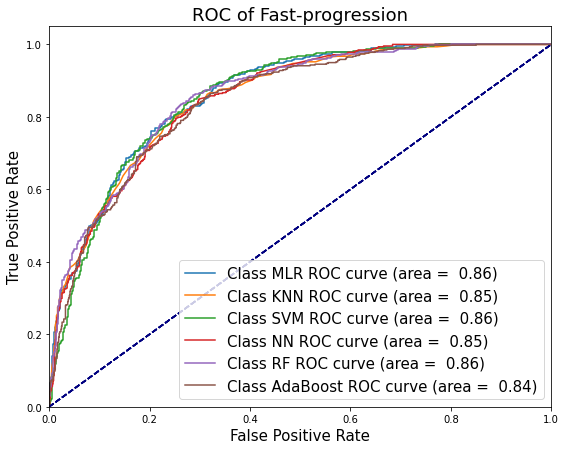

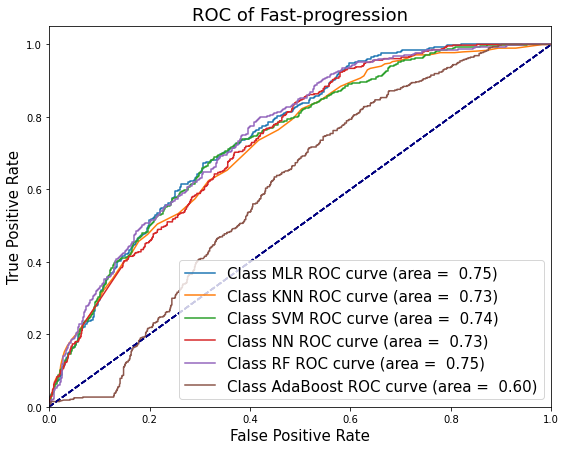

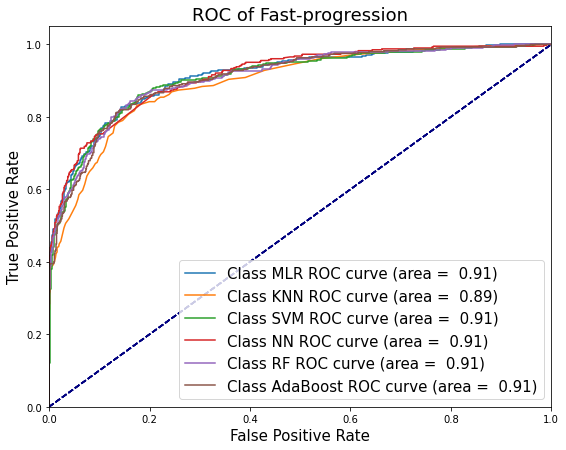

In [148]:
import sklearn
def plot_roc_curve(y_true_one_hot, y_score, label, title):
    '''
    y_true is one hot encodings of the class labels
    y_score is the target scores, such as be probability estimates of the positive class
    
    both y_true and y_score are of shape (n_samples, n_classes)
    '''
    n_class = y_score.shape[1]
    # plt.figure(figsize=(12,10))
    lw = 1.5
    for j in range(n_class):
        y_prob = y_score[:,j]
        y_true = y_true_one_hot[:,j]
        
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_prob, pos_label=1)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.figure(j,figsize=(9,7))
        plt.plot(
            fpr,
            tpr,
            lw=lw,
            label=f"Class {label} ROC curve (area = {roc_auc: 0.2f})"
        )

        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.title("ROC of Fast-progression",fontsize=18)
        plt.legend(loc="lower right",fontsize=15)
    # plt.show()

def plot_roc_curves_all(y_true_one_hot, all_scores, method_names):
    n_methods = len(all_scores)
    title = ["ROC of No-progression"]
    for i in range(n_methods):
        y_score = all_scores[i]
        method = method_names[i]
        plot_roc_curve(y_true_one_hot, y_score, method,title)

    plt.show()

y_test_bin = label_binarize(y_test, classes=range(0,3))
all_scores = [y_score_multinom, y_score_knn, y_score_svm, y_score_mlp, y_score_rf, y_score_abc]
method_names = ['MLR', 'KNN', 'SVM', 'NN', 'RF', 'AdaBoost']

plot_roc_curves_all(y_test_bin, all_scores, method_names)

In [140]:
title = ["ROC of Non-progression", "ROC of Slow-progression", "ROC of Fast-progression"]

title[1]

'ROC of Slow-progression'